# Cleaning: Population Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Load csv
pop_df = pd.read_csv("New_York_City_Population_by_Borough__1950_-_2040.csv")
pop_df.columns = pop_df.columns.str.strip()  # delete any extra spaces in col name

# only total population
pop_2020_df = pop_df[pop_df["Age Group"] == "Total Population"][["Borough", "2020"]].copy()

# clean up names
pop_2020_df["Borough"] = pop_2020_df["Borough"].str.strip().str.title()

# drop total
pop_2020_df = pop_2020_df[pop_2020_df["Borough"] != "Nyc Total"]

# dict
borough_pop = pop_2020_df.set_index("Borough")["2020"].to_dict()


NameError: name 'pd' is not defined

Loaded and cleaned file: nyc-park-crime-stats-q1-2024.xlsx as 2024_Q1
Cleaned DataFrame Head:
                            PARK        BOROUGH  SIZE (ACRES)  \
0                PELHAM BAY PARK          Bronx      2771.747   
1   ROCKAWAY BEACH AND BOARDWALK         Queens      1072.564   
2                FRESHKILLS PARK  Staten Island       913.320   
3   FLUSHING MEADOWS CORONA PARK         Queens       897.690   
4  LATOURETTE PARK & GOLF COURSE  Staten Island       843.970   

             CATEGORY  MURDER  RAPE  ROBBERY  FELONY ASSAULT  BURGLARY  \
0  ONE ACRE OR LARGER     0.0   0.0      0.0             0.0       0.0   
1  ONE ACRE OR LARGER     0.0   0.0      0.0             0.0       0.0   
2  ONE ACRE OR LARGER     0.0   0.0      0.0             0.0       0.0   
3  ONE ACRE OR LARGER     0.0   0.0      0.0             3.0       0.0   
4  ONE ACRE OR LARGER     0.0   0.0      0.0             0.0       0.0   

   GRAND LARCENY  GRAND LARCENY OF MOTOR VEHICLE  TOTAL  quarter  
0  

/var/folders/2_/kj4_b56n0ss4q5yy7w6dt2y00000gn/T/ipykernel_6874/3053372058.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=crime_by_borough, x='BOROUGH', y='Crimes_per_capita', palette='viridis')  # modified


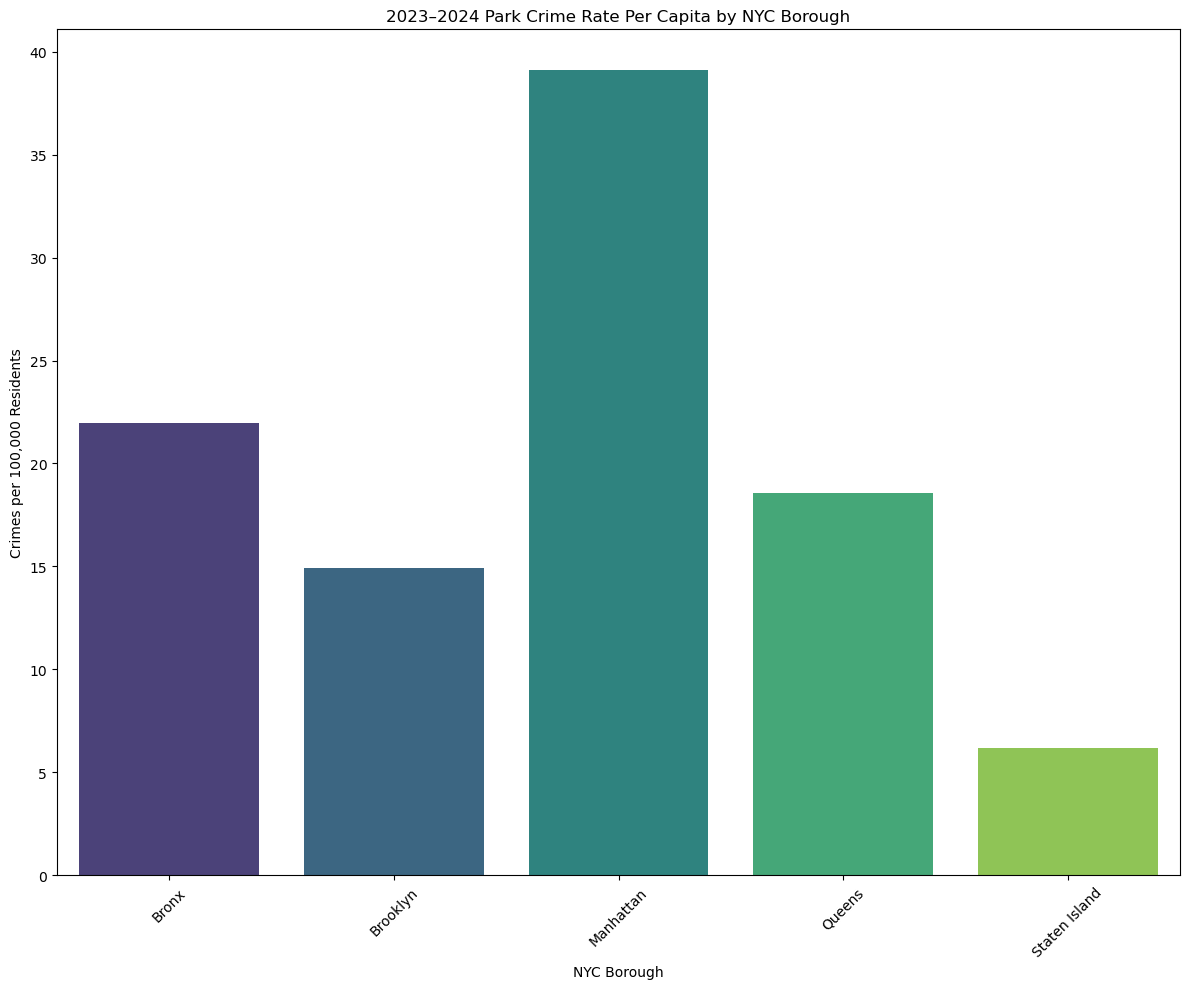

<Figure size 1200x1000 with 0 Axes>

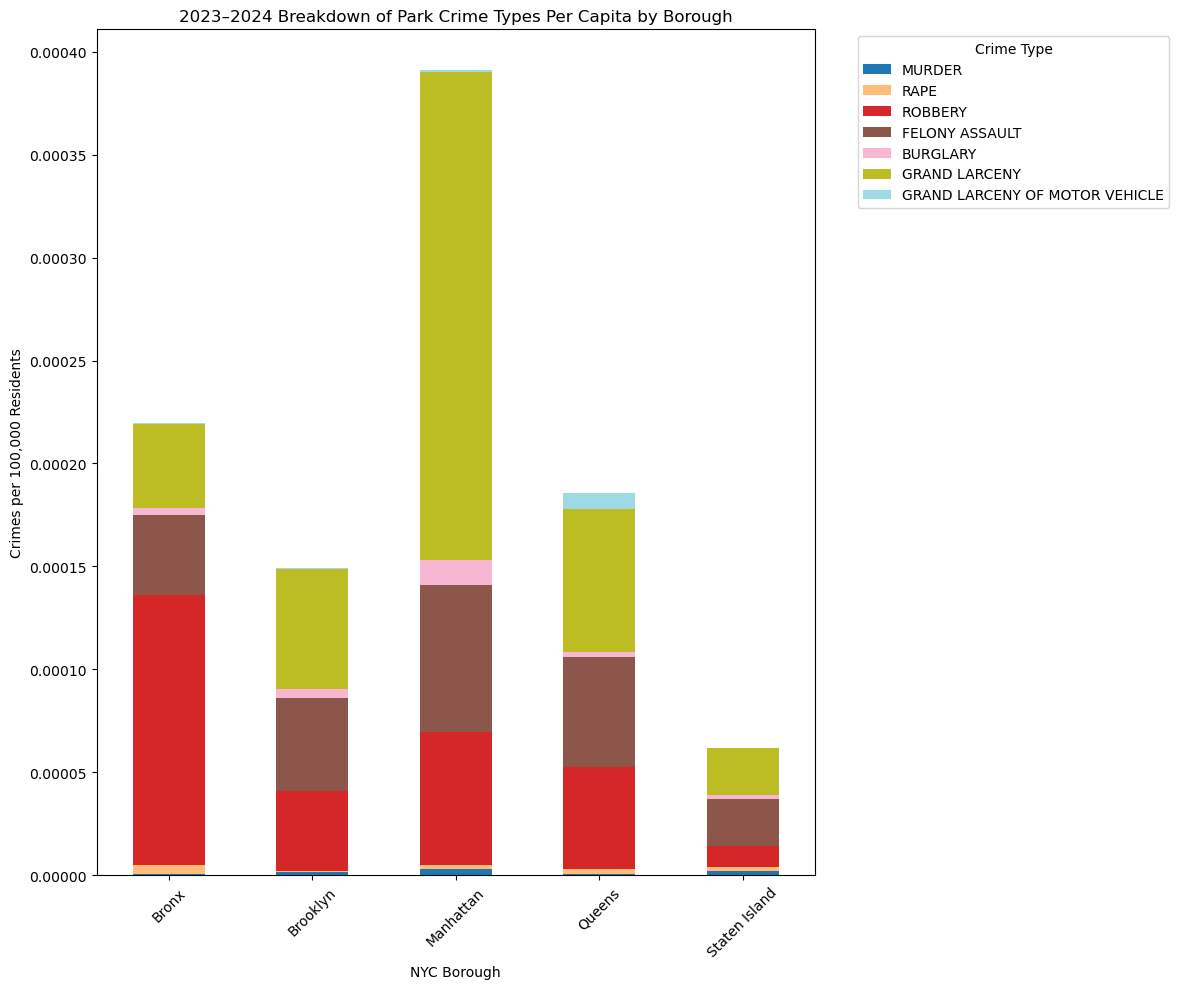

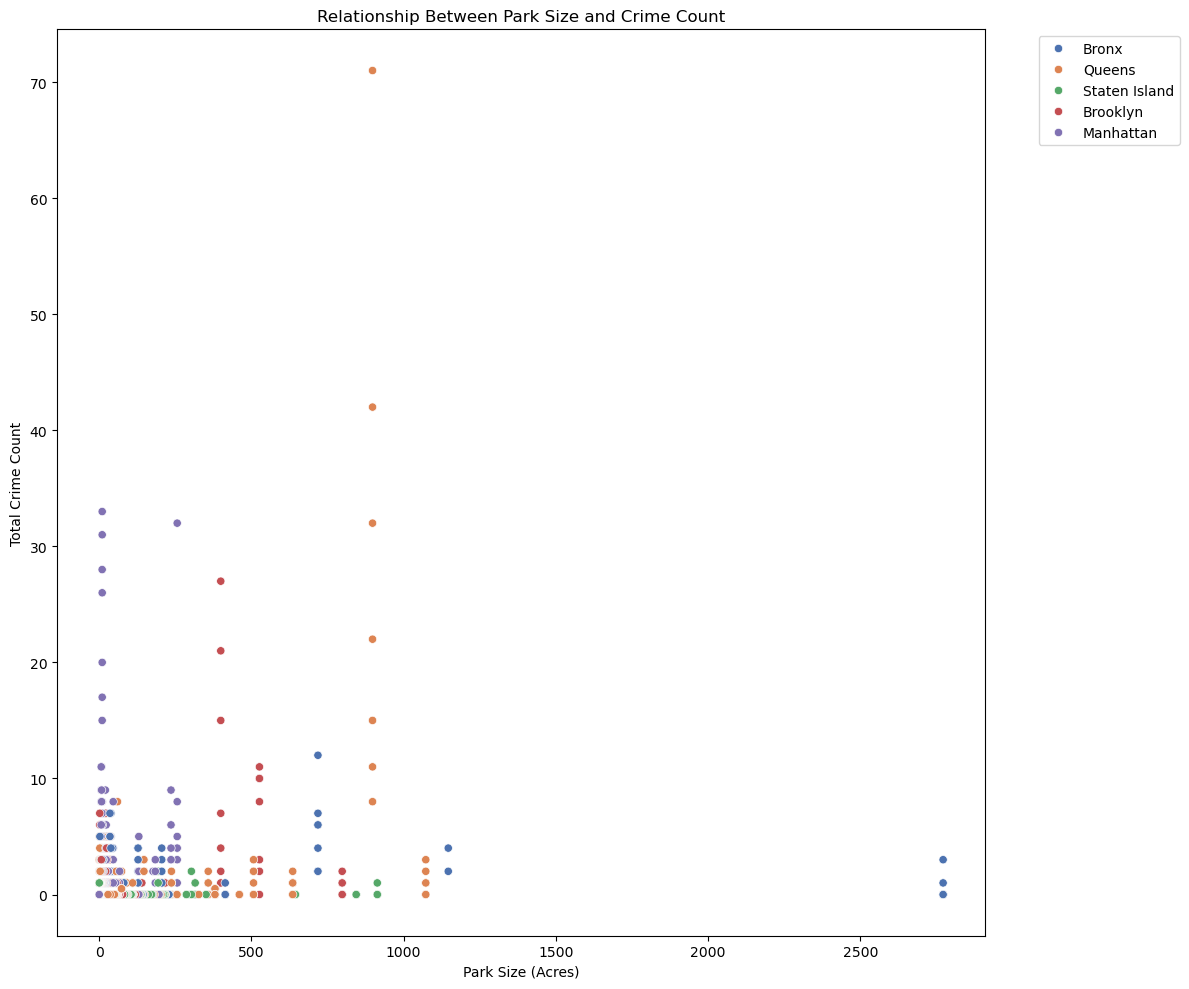

In [ ]:
def read_all_sheets_from_excel(filepath):
    """Read all sheets from an Excel file into a dictionary of dataframes"""
    xl = pd.ExcelFile(filepath)
    return {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

filepaths = {
    '2024_Q1': 'nyc-park-crime-stats-q1-2024.xlsx',
    '2024_Q2': 'nyc-park-crime-stats-q2-2024.xlsx',
    '2024_Q3': 'nyc-park-crime-stats-q3-2024.xlsx',
    '2024_Q4': 'nyc-park-crime-stats-q4-2024.xlsx',
    '2023_Q1': 'nyc-park-crime-stats-q1-2023.xlsx',
    '2023_Q2': 'nyc-park-crime-stats-q2-2023.xlsx',
    '2023_Q3': 'nyc-park-crime-stats-q3-2023.xlsx',
    '2023_Q4': 'nyc-park-crime-stats-q4-2023.xlsx'
}

list_of_dfs = []

for key, fp in filepaths.items():
    try:
        all_sheets = read_all_sheets_from_excel(fp)
        sheet_name = list(all_sheets.keys())[0]
        df = all_sheets[sheet_name]

        df = all_sheets[sheet_name]

        # Clean and preserve original header row
        df = df.drop(index=1).reset_index(drop=True)  # Drop only the second row if it's garbage

        # Ensure column names are clean and valid
        df.columns = df.columns.astype(str).str.strip()

        # Drop duplicate columns, just in case
        df = df.loc[:, ~df.columns.duplicated()]

        # Fix borough names
        df["BOROUGH"] = df["BOROUGH"].str.strip().str.title()

        # Split 'Brooklyn/Queens' rows in half
        if "Brooklyn/Queens" in df["BOROUGH"].values:
            bq_rows = df[df["BOROUGH"] == "Brooklyn/Queens"]
            bq_brooklyn = bq_rows.copy()
            bq_brooklyn["BOROUGH"] = "Brooklyn"
            bq_brooklyn[numeric_columns] = bq_brooklyn[numeric_columns] / 2

            bq_queens = bq_rows.copy()
            bq_queens["BOROUGH"] = "Queens"
            bq_queens[numeric_columns] = bq_queens[numeric_columns] / 2

            df = df[df["BOROUGH"] != "Brooklyn/Queens"]
            df = pd.concat([df, bq_brooklyn, bq_queens], ignore_index=True)



        df['quarter'] = key
        list_of_dfs.append(df)
        print('Loaded and cleaned file: ' + fp + ' as ' + key)
        print("Cleaned DataFrame Head:")
        print(df.head())
    except Exception as e:
        print('Error loading file: ' + fp + ' with error ' + str(e))

combined_df = pd.concat(list_of_dfs, ignore_index=True)

combined_df["BOROUGH"] = combined_df["BOROUGH"].str.strip().str.title()

# Compute per capita crime
combined_df["Crimes_per_capita"] = combined_df.apply(
    lambda row: (row["TOTAL"] / borough_pop.get(row["BOROUGH"], 1)) * 100000, axis=1
)
combined_df["Crimes_per_capita"] = combined_df["Crimes_per_capita"].round(8)

combined_df.columns = [col.strip() for col in combined_df.columns]

numeric_columns = ['SIZE (ACRES)', 'MURDER', 'RAPE', 'ROBBERY', 'FELONY ASSAULT',
                   'BURGLARY', 'GRAND LARCENY', 'GRAND LARCENY OF MOTOR VEHICLE', 'TOTAL']
for col in numeric_columns:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce').fillna(0)

print('Combined DataFrame head:')
print(combined_df.head())

# Visualization 1: Bar chart showing crime distribution by borough
# crime_by_borough = combined_df.groupby('BOROUGH')['TOTAL'].sum().reset_index()
crime_by_borough = combined_df.groupby('BOROUGH')['Crimes_per_capita'].sum().reset_index() # modified

plt.figure(figsize=(12, 10))
# bar_plot = sns.barplot(data=crime_by_borough, x='BOROUGH', y='TOTAL', palette='viridis')
bar_plot = sns.barplot(data=crime_by_borough, x='BOROUGH', y='Crimes_per_capita', palette='viridis')  # modified

plt.title('2023–2024 Park Crime Rate Per Capita by NYC Borough') 
plt.xlabel('NYC Borough') 
plt.ylabel('Crimes per 100,000 Residents')  
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pc_crime_distribution_barchart.png')
plt.show()

# Visualization 2: Stacked bar chart that compares different crime types by borough
crime_types = ['MURDER', 'RAPE', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY',
               'GRAND LARCENY OF MOTOR VEHICLE']
crime_by_type = combined_df.groupby('BOROUGH')[crime_types].sum()

for col in crime_types:
    crime_by_type[col] = crime_by_type[col] / crime_by_type.index.map(borough_pop)  # Per capita normalization

plt.figure(figsize=(12, 10))
crime_by_type.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='tab20')
plt.title('2023–2024 Breakdown of Park Crime Types Per Capita by Borough') 
plt.xlabel('NYC Borough') 
plt.ylabel('Crimes per 100,000 Residents')   
plt.xticks(rotation=45)
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('pc_crime_types_stacked.png')
plt.show()


# Visualization 3: Scatter plot analyzing relationship between park size and crime count
plt.figure(figsize=(12, 10))
scatter_plot = sns.scatterplot(data=combined_df, x='SIZE (ACRES)', y='TOTAL', hue='BOROUGH', palette='deep')
plt.title('Relationship Between Park Size and Crime Count')
plt.xlabel('Park Size (Acres)')
plt.ylabel('Total Crime Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('pc_parksize_vs_crime.png')
plt.show()
